In [1]:
import tensorflow as tf
import numpy as np
import scipy.misc as misc
from PIL import Image
import os,itertools
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

In [2]:
batch_size = 5
epsilon = 1e-8

alpha = 5e-5
beta = 0.1 * alpha

num_epoch = 100

In [43]:
def display_image(i,w,h):
    img = Image.open("Images/"+i+".jpg")
    img = img.resize((w, h), Image.ANTIALIAS)
    display(img)

In [3]:
def conv_layer(scope, inputs, kernal_size,filters, stride, padding):
    
    w_initializer = tf.truncated_normal_initializer(stddev=0.01)
    b_initializer = tf.constant_initializer(1)
    
    shape = [kernal_size, kernal_size, int(inputs.shape[-1]), filters]
    
    w = tf.get_variable(scope+"_w", shape = shape, initializer=w_initializer)
    b = tf.get_variable(scope+"_b", [filters], initializer=b_initializer)
    
    conv = tf.nn.conv2d(inputs, w, [1, stride, stride, 1], padding) + b
    
    return conv


def deconv_layer(scope, inputs, kernal_size,filters, stride, padding):
    
    w_initializer = tf.truncated_normal_initializer(stddev=0.01)
    b_initializer = tf.constant_initializer(1)
    
    shape = [kernal_size, kernal_size, filters, int(inputs.shape[-1])]
    
    B,H,W = int(inputs.shape[0]), int(inputs.shape[1]), int(inputs.shape[2])
    
    w = tf.get_variable(scope+"_w", shape = shape, initializer=w_initializer)
    b = tf.get_variable(scope+"_b", [filters], initializer=b_initializer)
    
    deconv = tf.nn.conv2d_transpose(inputs, w, [B, int(H*stride), int(W*stride), filters], [1, stride, stride, 1], padding) + b
    
    return deconv


def fully_connected_layer(scope,inputs,outputs):
    
    w_initializer = tf.truncated_normal_initializer(stddev=0.01)
    b_initializer = tf.constant_initializer(1)
    
    flatten = tf.layers.flatten(inputs).shape[-1]

    w = tf.get_variable(scope+"_w", [flatten, outputs], initializer=w_initializer)
    b = tf.get_variable(scope+"_b", [outputs], initializer=b_initializer)
    
    logits_fc = tf.matmul(inputs,w) + b    
    
    return logits_fc




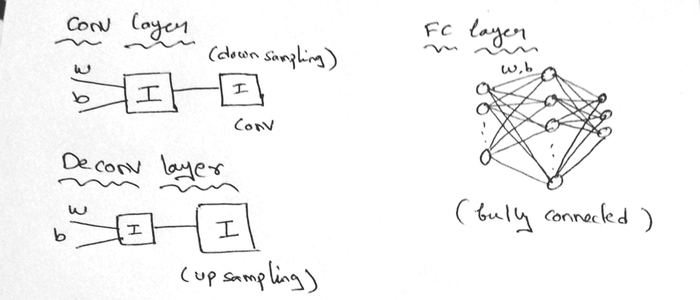

In [45]:
display_image("1",700,300)

In [10]:
def leaky_relu(inputs, alpha=0.1):
    return tf.maximum(inputs, alpha*inputs)

def batch_norm(x, scope_bn):
    
    with tf.variable_scope(scope_bn, reuse=tf.AUTO_REUSE):
        
        beta = tf.get_variable("beta", [x.shape[-1]], initializer=tf.constant_initializer(0.0), trainable=True)
        gamma = tf.get_variable("gamma", [x.shape[-1]], initializer=tf.constant_initializer(1.0), trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments', keep_dims=True) #each the channel has its mean and var
        
        batch_norm = ((x - batch_mean) / tf.sqrt(batch_var + epsilon)) * gamma + beta
        
        return leaky_relu(batch_norm)


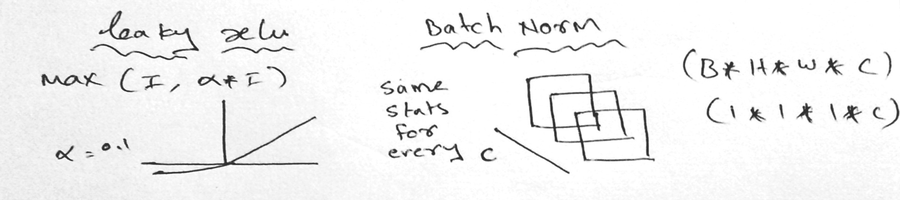

In [46]:
display_image("2",900,200)

In [12]:
def generator(scope,x, reuse=True):
    
    with tf.variable_scope(scope, reuse=reuse):
        
        x1 = batch_norm(conv_layer("conv1",x,5,64,1,"SAME"),"conv1")
        x2 = batch_norm(conv_layer("conv2",x1,4,128,2,"SAME"),"conv2")
        x3 = batch_norm(conv_layer("conv3",x2,4,256,2,"SAME"),"conv3")
        
        x4 = batch_norm(deconv_layer("deconv4",x3,3,128,2,"SAME"),"deconv4")
        x5 = batch_norm(deconv_layer("deconv5",x4,3,64,2,"SAME"),"deconv5")
    
        logits = conv_layer("conv6", x5, 4, 3, 1, "SAME")
        
        return logits

def discriminator(scope,x, reuse=True):
    
    with tf.variable_scope(scope, reuse=reuse):
        
        x1 = batch_norm(conv_layer("conv1",x,4,32,2,"SAME"),"conv1")
        x2 = batch_norm(conv_layer("conv2",x1,4,64,2,"SAME"),"conv2")
        x3 = batch_norm(conv_layer("conv3",x2,4,128,2,"SAME"),"conv3")
        x4 = batch_norm(conv_layer("conv4",x3,4,256,2,"SAME"),"conv4")
        x5 = batch_norm(conv_layer("conv5",x4,4,512,2,"SAME"),"conv5")

        x6 = conv_layer("conv6", x5, 4, 512, 1, "VALID")
        x6 = tf.squeeze(x6)

        logits = fully_connected_layer("fc",x6,3)
        logits = tf.squeeze(logits)

        return logits,x3


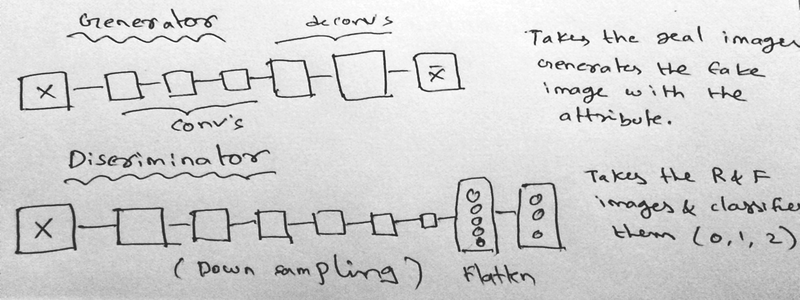

In [47]:
display_image("3",800,300)

In [6]:
data_path_pos = "Young/" #+1
data_path_neg = "Old/" #-1

pos_images = os.listdir(data_path_pos)[:5000]
neg_images = os.listdir(data_path_neg)[:5000]

def get_data():
    
    trainX0,trainX1 = [],[]
    
    for p,n in zip(pos_images,neg_images):
        img =np.array(Image.open(data_path_neg + n))
        img = np.array(Image.fromarray(img).resize([128,128]))
        trainX0.append(img)
        
        img = np.array(Image.open(data_path_pos + p))
        img = np.array(Image.fromarray(img).resize([128,128]))
        trainX1.append(img)

    return np.array(trainX0),np.array(trainX1)

def shuffle_data():
    np.random.shuffle(trainX0)
    np.random.shuffle(trainX1)
    
trainX0,trainX1 = get_data()

In [7]:
def show_images(trainX):

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(15, 15))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(size_figure_grid*size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(trainX[k])

    plt.show()

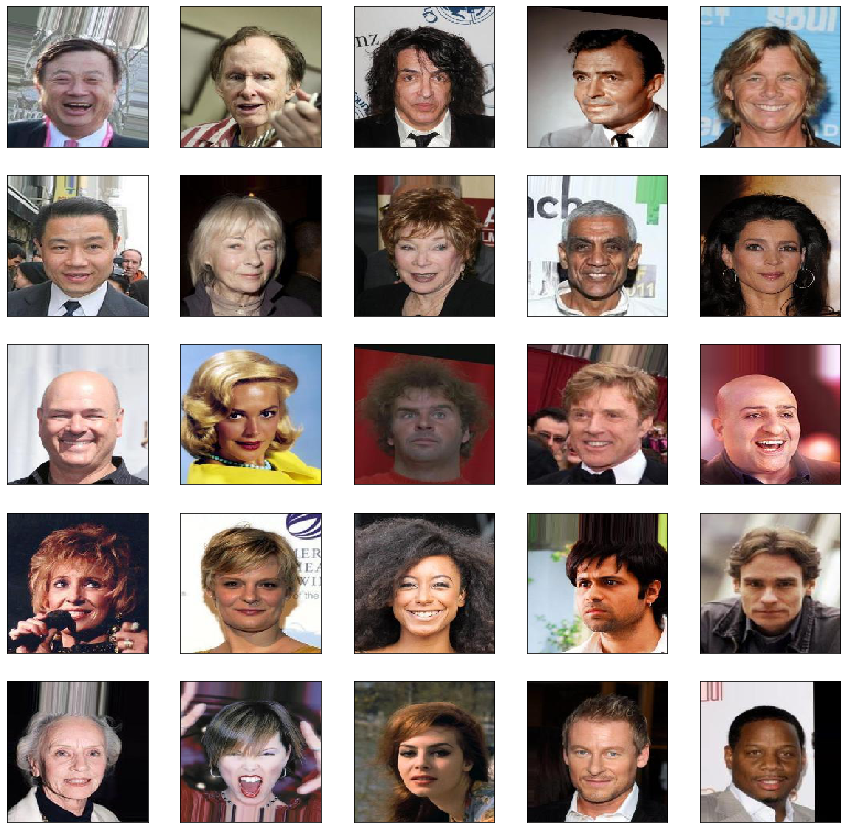

In [8]:
show_images(trainX0)

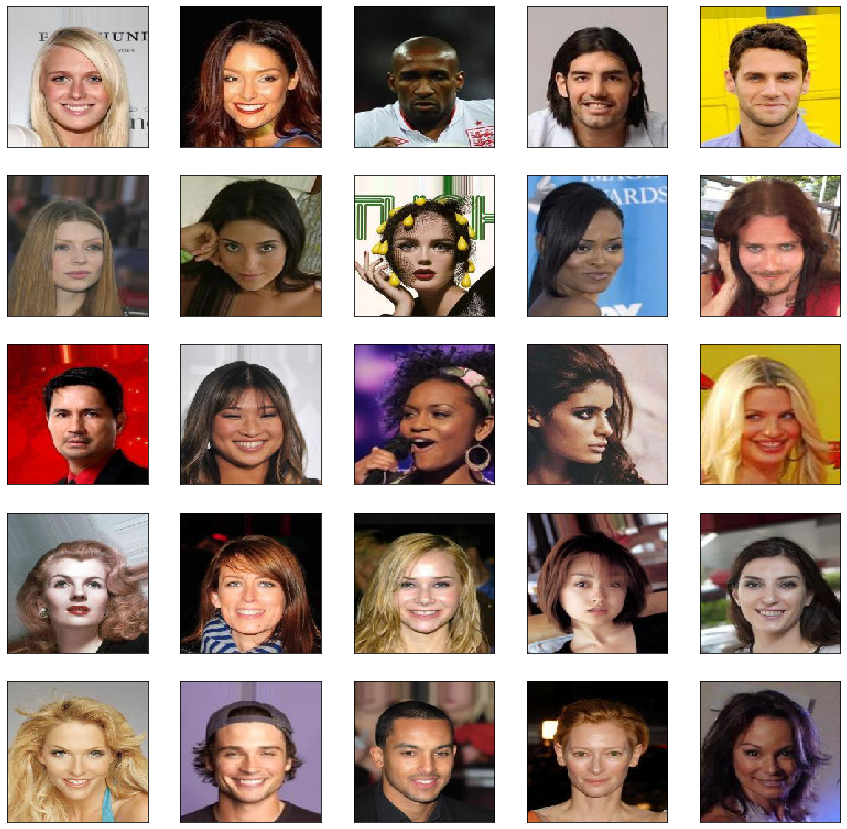

In [9]:
show_images(trainX1)

In [10]:
x0 = tf.placeholder("float", [batch_size, 128, 128, 3])
x1 = tf.placeholder("float", [batch_size, 128, 128, 3])

In [11]:
r0_logits = generator("G0",x0,False)
r1_logits = generator("G1",x1,False)

x0_concat = x0+r0_logits
x1_concat = x1+r1_logits

d_fake_x0_logits,d_fake_x0_layer3_logits = discriminator("D",x0_concat,False)
d_fake_x1_logits,d_fake_x1_layer3_logits = discriminator("D",x1_concat,True)

d_real_x0_logits,d_real_x0_layer3_logits = discriminator("D",x0,True)
d_real_x1_logits,d_real_x1_layer3_logits = discriminator("D",x1,True)

rec_r0_logits = generator("G1",x0_concat,True)
rec_r1_logits = generator("G0",x1_concat,True)

rec_x0_concat = x0_concat + rec_r0_logits
rec_x1_concat = x1_concat + rec_r1_logits

dual_x0_logits,dual_x0_layer3_logits = discriminator("D",rec_x0_concat,True)
dual_x1_logits,dual_x1_layer3_logits = discriminator("D",rec_x1_concat,True)


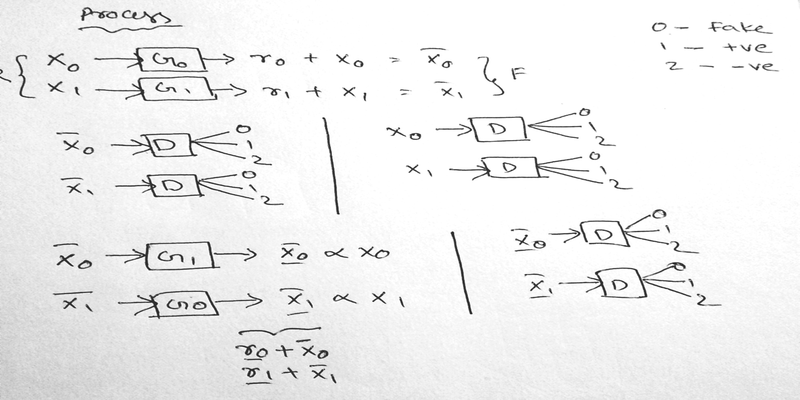

In [48]:
display_image("4",800,400)

In [12]:
labels_fake = tf.one_hot(np.full([batch_size],0), 3)  # [1 0 0]
labels_pos = tf.one_hot(np.full([batch_size],1), 3)   # [0 1 0]
labels_neg = tf.one_hot(np.full([batch_size],2), 3)   # [0 0 1]

In [13]:
D_loss_fake_x0 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_x0_logits, 
                                                                        labels=labels_fake))

D_loss_fake_x1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_x1_logits, 
                                                                        labels=labels_fake))


D_loss_real_x0 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_x0_logits, 
                                                                        labels=labels_neg))

D_loss_real_x1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_x1_logits, 
                                                                        labels=labels_pos))


D_loss = D_loss_fake_x0 + D_loss_fake_x1 + D_loss_real_x0 + D_loss_real_x1


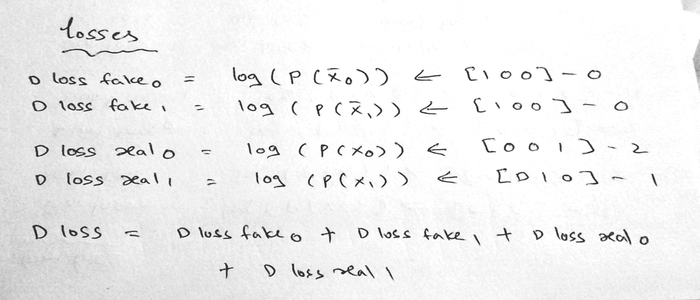

In [49]:
display_image("5",700,300)

In [14]:
l1_norm_r0 = tf.reduce_mean(tf.reduce_sum(tf.abs(r0_logits), axis=[1, 2, 3]))
l1_norm_r1 = tf.reduce_mean(tf.reduce_sum(tf.abs(r1_logits), axis=[1, 2, 3]))

l_per_x0 = tf.reduce_mean(tf.reduce_sum(tf.abs(d_real_x0_layer3_logits - d_fake_x0_layer3_logits), axis=[1, 2, 3]))
l_per_x1 = tf.reduce_mean(tf.reduce_sum(tf.abs(d_real_x1_layer3_logits - d_fake_x1_layer3_logits), axis=[1, 2, 3]))


G_log_loss_x0 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_x0_logits, 
                                                                        labels=labels_pos))

G_log_loss_x1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_x1_logits, 
                                                                        labels=labels_neg))


dual_loss_x0 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dual_x0_logits, 
                                                                        labels=labels_neg))

dual_loss_x1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dual_x1_logits, 
                                                                        labels=labels_pos))


G0_loss = G_log_loss_x0 + dual_loss_x0 + alpha * l1_norm_r0 + beta * l_per_x0
G1_loss = G_log_loss_x1 + dual_loss_x1 + alpha * l1_norm_r1 + beta * l_per_x1


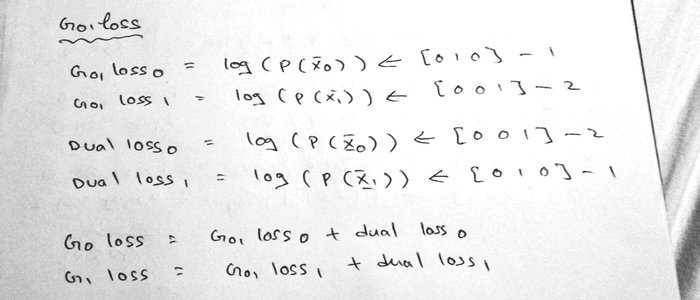

In [50]:
display_image("6",700,300)

In [15]:
G0_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'G0')
G1_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'G1')
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'D')

D_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(D_loss, var_list=D_vars)
G0_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(G0_loss, var_list=G0_vars)
G1_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(G1_loss, var_list=G1_vars)

In [16]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [17]:
def normalize(img):
    return 255.0 * (img - np.min(img)) / (np.max(img) - np.min(img))

def show_result(x0,r0,x1,name):

    images = []
    
    for i in range(5):
        images.append(x0[i])
        images.append(normalize(r0[i]))
        images.append(x1[i])

    fig=plt.figure(figsize=(10, 9))
    columns = 3
    rows = 5
        
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(np.uint8(images[i]))
    
    fig.text(0.5, 0.04, name, ha='center')
    plt.show()

def printLog(epoch,batch,D_loss,G0_loss,G1_loss,dual_loss_x0,dual_loss_x1):
    print('Epoch: {} Image : {} '.format(epoch,batch))
    print('D loss: {:.4}'. format(D_loss))
    print('G0 loss: {:.4}'.format(G0_loss))
    print('G1 loss: {:.4}'.format(G1_loss))
    print('Dual Loss x0: {:.4}'.format(dual_loss_x0))
    print('Dual Loss x1: {:.4}'.format(dual_loss_x1))
    print()

Epoch: 0 Image : 0 
D loss: 7.546
G0 loss: 5.718
G1 loss: 5.756
Dual Loss x0: 2.615
Dual Loss x1: 2.39



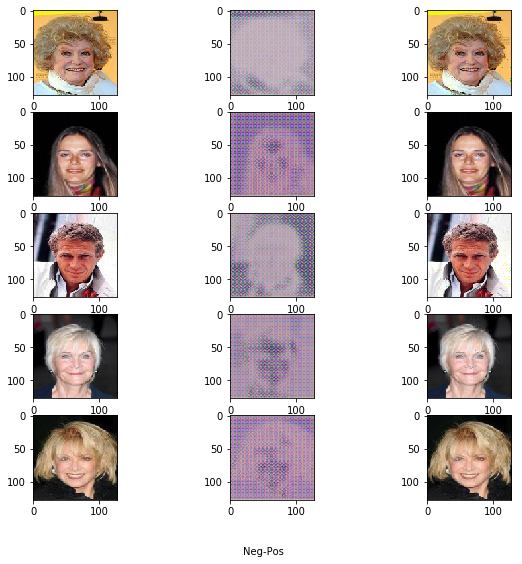

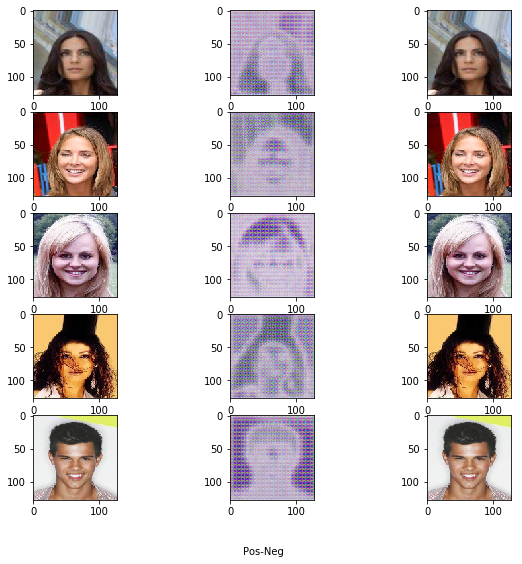

Epoch: 0 Image : 5 
D loss: 5.814
G0 loss: 6.299
G1 loss: 6.312
Dual Loss x0: 3.147
Dual Loss x1: 2.613



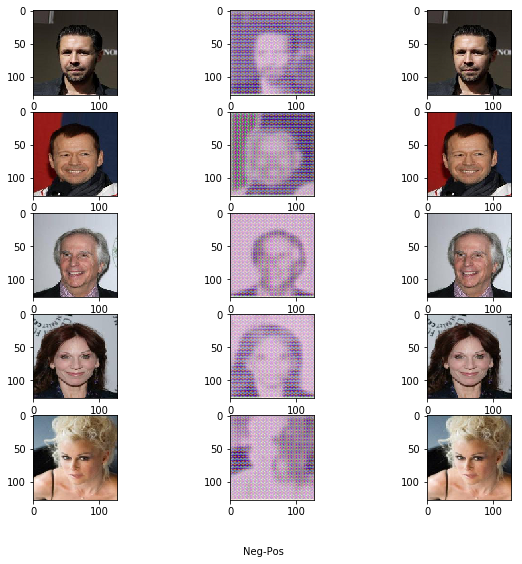

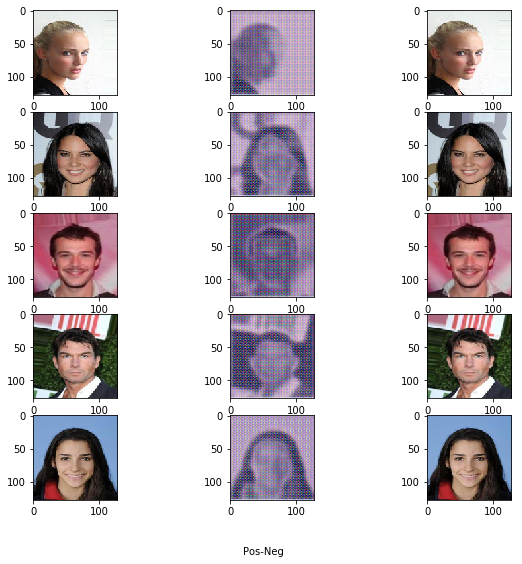

Epoch: 0 Image : 10 
D loss: 3.277
G0 loss: 1.626
G1 loss: 1.328
Dual Loss x0: 0.2255
Dual Loss x1: 0.4962



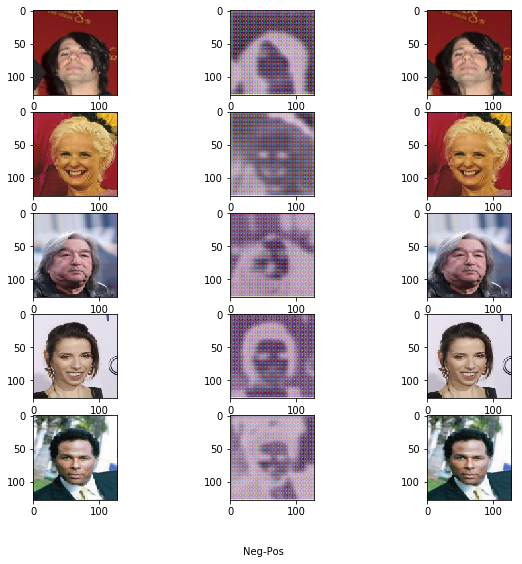

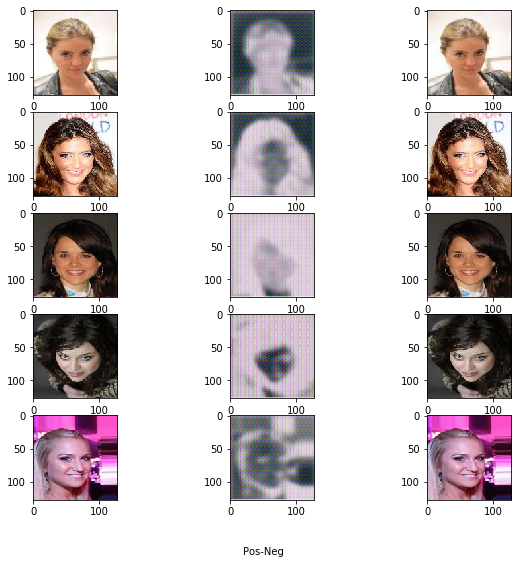

Epoch: 0 Image : 15 
D loss: 3.247
G0 loss: 2.917
G1 loss: 3.35
Dual Loss x0: 1.072
Dual Loss x1: 0.8521



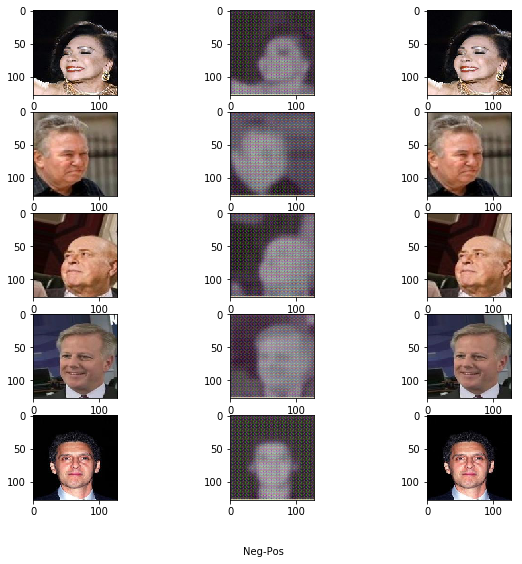

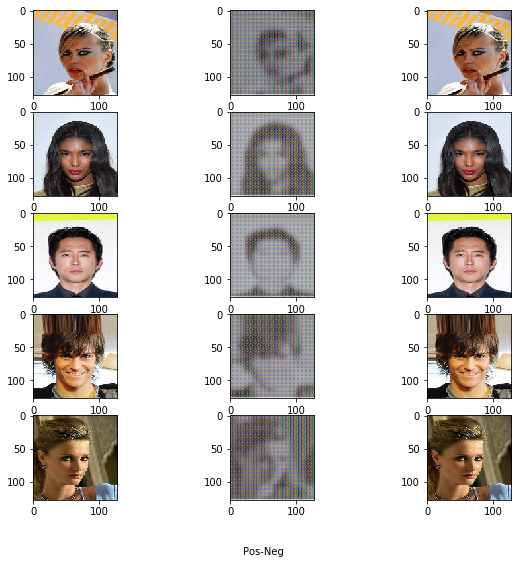

Epoch: 0 Image : 20 
D loss: 3.848
G0 loss: 2.601
G1 loss: 2.878
Dual Loss x0: 1.857
Dual Loss x1: 0.4251



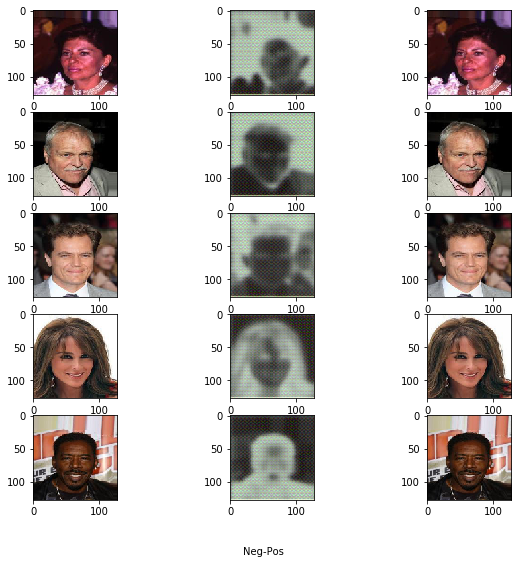

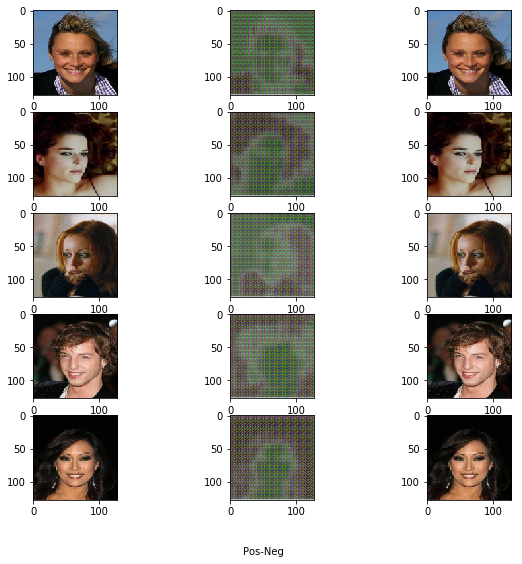

Epoch: 0 Image : 25 
D loss: 3.063
G0 loss: 2.94
G1 loss: 2.66
Dual Loss x0: 0.988
Dual Loss x1: 1.598



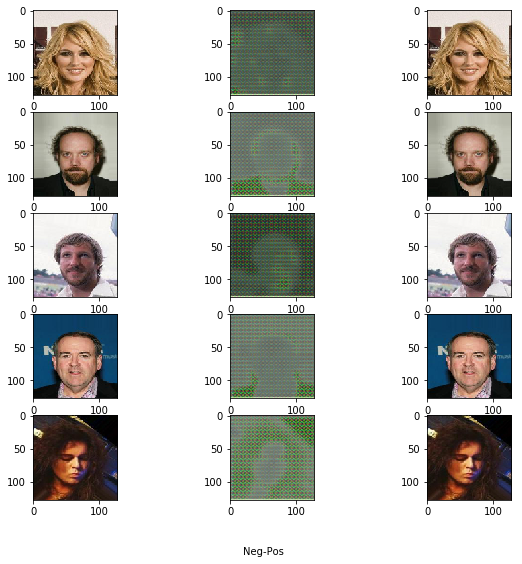

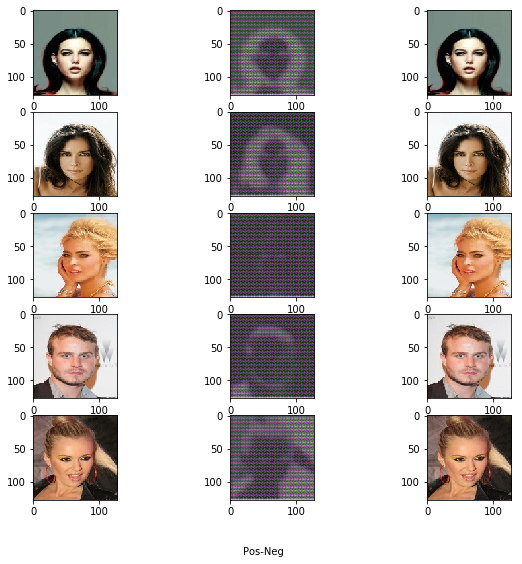

Epoch: 0 Image : 30 
D loss: 3.027
G0 loss: 1.98
G1 loss: 1.163
Dual Loss x0: 0.1645
Dual Loss x1: 0.5741



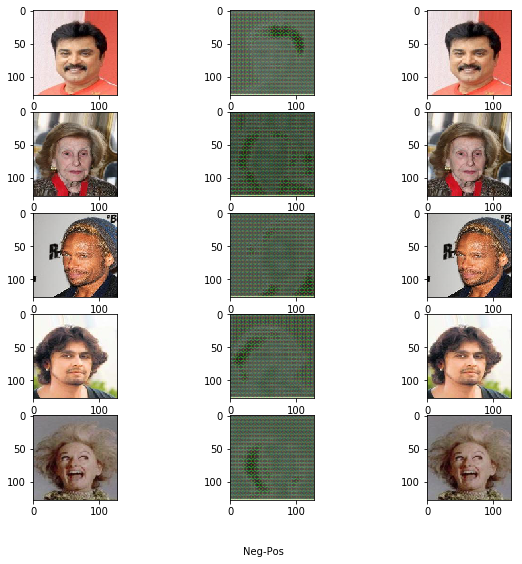

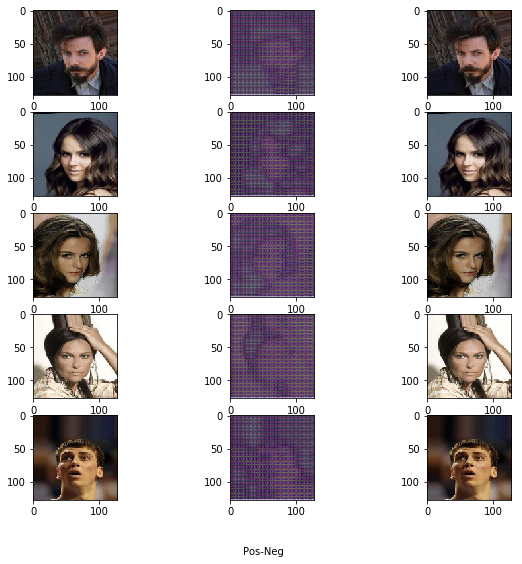

KeyboardInterrupt: 

In [18]:
tf.reset_default_graph()

for epoch in range(2):
    
    shuffle_data()
    
    for current_batch_index in range(0,len(trainX0),5):
        batch_x0 = trainX0[current_batch_index:current_batch_index+batch_size,:,:,:]
        batch_x1 = trainX1[current_batch_index:current_batch_index+batch_size,:,:,:]
        
        sess.run(D_solver, feed_dict={x0: batch_x0, x1: batch_x1})
        sess.run(G0_solver, feed_dict={x0:batch_x0,x1: batch_x1})
        sess.run(G1_solver, feed_dict={x0: batch_x0, x1: batch_x1})
        
        if current_batch_index%1 == 0:
            
            feed_dict = {x0:batch_x0,x1: batch_x1}
            
            r0 = sess.run(r0_logits,feed_dict = feed_dict) 
            r1 = sess.run(r1_logits,feed_dict = feed_dict)

            gen_x0 = sess.run(x0_concat,feed_dict = feed_dict)
            gen_x1 = sess.run(x1_concat,feed_dict = feed_dict)

            d_loss,g0_loss,g1_loss,dual_lossx0,dual_lossx1 = sess.run([D_loss,G0_loss,G1_loss,dual_loss_x0,dual_loss_x1],feed_dict = feed_dict)
            
            printLog(epoch,current_batch_index,d_loss,g0_loss,g1_loss,dual_lossx0,dual_lossx1)
            show_result(batch_x0,r0,gen_x0,"Neg-Pos")
            show_result(batch_x1,r1,gen_x1,"Pos-Neg")
            
            